In [5]:
######################################################################
######################### 댓글 크롤링 시작 ############################
######################################################################

import urllib.parse as rep
import urllib.request as req
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
import gzip
import pandas as pd
import json
import time
import pandas as pd
from hanspell import spell_checker

In [ ]:


# Header 정보 초기화
opener = req.build_opener()
# User-Agent 정보
#opener.addheaders = [('User-agent', UserAgent())]
# Header 정보 삽입
req.install_opener(opener)

# 쇼핑 댓글 요청 헤더
# https://search.shopping.naver.com/catalog/24178126692?cat_id=50000814&nv_mid=24178126692&NaPm=ct%3Dkmochwcg%7Cci%3D5fbcf90319f44a9577a7ba53d9afec4cf0af44e8%7Ctr%3Dsl%7Csn%3D95694%7Chk%3D180c476dc3ec1764ae9d356ee403773d5f2382ca
# https://search.shopping.naver.com/catalog/14742158672?NaPm=ct%3Dkmyyltb4%7Cci%3D8fb2739c338be12299472ccff160ded9bc19122f%7Ctr%3Dslsl%7Csn%3D95694%7Chk%3D0186b9292ab060733115318dcfd65d3aefb527b7

    
# Request
flag = True
pageNum = 1
result = []
count = 0
while flag:
    
    print(len(result))
    # Throttle 설정
    time.sleep(0.7)
    try:
        
        # 쇼핑 댓글 요청 헤더
        hdr = {'authority': 'search.shopping.naver.com', \
        'method': 'GET',\
        'path': '/review?nvMid=14742158672&reviewType=ALL&sort=QUALITY&isNeedAggregation=N&isApplyFilter=N&page='+str(pageNum)+'&pageSize=20',\
        'scheme': 'https',\
        'accept': 'application/json, text/plain, */*',\
        'accept-encoding': 'gzip, deflate, br',\
        'accept-language': 'ko-KR,ko;q=0.9,en-US;q=0.8,en;q=0.7',\
        'cache-control': 'no-cache',\
        'pragma': 'no-cache',\
        'referer': 'https://search.shopping.naver.com/catalog/14742158672?NaPm=ct%3Dkmyyltb4%7Cci%3D8fb2739c338be12299472ccff160ded9bc19122f%7Ctr%3Dslsl%7Csn%3D95694%7Chk%3D0186b9292ab060733115318dcfd65d3aefb527b7',\
        'sec-ch-ua': '"Google Chrome";v="89", "Chromium";v="89", ";Not A Brand";v="99"',\
        'sec-ch-ua-mobile': '?0',\
        'sec-fetch-dest': 'empty',\
        'sec-fetch-mode': 'cors',\
        'sec-fetch-site': 'same-origin',\
        'urlprefix': '/api',\
        'user-agent': 'M'}

        url = 'https://search.shopping.naver.com/review?nvMid=14742158672&reviewType=ALL&sort=QUALITY&isNeedAggregation=N&isApplyFilter=N&page='+str(pageNum)+'&pageSize=20'        
        
        reqeust = req.Request(url,headers=hdr)
        res = gzip.decompress(req.urlopen(reqeust).read()).decode('utf-8')
        
        data = json.loads(res)
        result.extend(data['reviews'])
        pageNum = pageNum + 1
        
        
    
    except Exception as e:
        
        # Too many request (429) 일 때 sleep 후 다시 요청
        if e.code == 429:
            print("429 error is occured")
            time.sleep(60)
        else:
            print(str(e))
            print('더 없음')
            flag = False


#res = req.urlopen(reqeust).read().decode('utf-8')



In [6]:


####################################################################################
######################## 저장된 크롤링 데이터 불러오기 ###############################
####################################################################################

#df = pd.DataFrame(result)
df = pd.read_csv('review_data.csv')
#df.to_csv('review_data.csv',sep=',', na_rep='NaN')
df.describe

<bound method NDFrame.describe of       Unnamed: 0   mallId mallProductId updateType  mallReviewId  mallSeq  \
0              0     evas     450072517     UPSERT     884568151   196900   
1              1  lgeshop      21606783     UPSERT     159716221        1   
2              2  lgeshop      21606783     UPSERT     161640758        1   
3              3  lgeshop      21606783     UPSERT     161686778        1   
4              4     evas     450072517     UPSERT     884651289   196900   
...          ...      ...           ...        ...           ...      ...   
9995        9995     evas    1001672838     UPSERT     309754686   196900   
9996        9996     evas    1001672838     UPSERT     309890694   196900   
9997        9997     evas    1001672838     UPSERT     307403606   196900   
9998        9998     evas     450072517     UPSERT     310322696   196900   
9999        9999     evas    1001672838     UPSERT     309654414   196900   

             nvMid   matchNvMid    userId

In [ ]:
len(result)

In [ ]:
result[6]

In [ ]:
######################################################################
######################### 댓글 크롤링 끝 ##############################
######################################################################

print(df.iloc[0]['content'])

In [ ]:
######################################################################
######################### 댓글 TextRank ##############################
######################################################################
#!pip install kobert-transformers

In [7]:
#형태소 분석기 Komoran

from konlpy.tag import Komoran

komoran = Komoran()
sent = '쑥 들어간 제품들을 평소에 좋아해서 쑥 화장품으로 대부분 쓰려고 해요 아침 저녁으로 매일 매일 쓰기에 부담이 없고 좋습니다자연약쑥 진정 토너라 자극없이 쓰기에도 좋고 녹차 루이보스 캐모마일 쑥 페퍼민트 로즈마리 유칼리투스잎이 들어간 그린 허브 성분이라 피부 진정에도 도움이 되는거 같아요'

words = komoran.pos(sent, join=True)
print(words )


['쑥/MAG', '들어가/VV', 'ㄴ/ETM', '제품/NNG', '들/XSN', '을/JKO', '평소/NNG', '에/JKB', '좋아하/VV', '아서/EC', '쑥/MAG', '화장품/NNG', '으로/JKB', '대부분/NNG', '쓰/VV', '려고/EC', '하/VV', '아요/EC', '아침/NNG', '저녁/NNG', '으로/JKB', '매일/MAG', '매일/MAG', '쓰/VV', '기/ETN', '에/JKB', '부담/NNG', '이/JKS', '없/VA', '고/EC', '좋/VA', '습니다/EC', '자연/NNG', '약/NNG', '쑥/NNG', '진정/NNP', '토너/NNP', '이/VCP', '라/EC', '자극/NNG', '없이/MAG', '쓰/VV', '기/ETN', '에/JKB', '도/JX', '좋/VA', '고/EC', '녹차/NNP', '루이보스/NNP', '캐모마일/NNP', '쑥/MAG', '페퍼/NNP', '민트/NNP', '로즈마리/NNP', '유칼리투스잎이/NA', '들어가/VV', 'ㄴ/ETM', '그리/VV', 'ㄴ/ETM', '허브/NNP', '성분/NNG', '이/VCP', '라/EC', '피부/NNP', '진정/NNG', '에/JKB', '도/JX', '도움/NNG', '이/JKS', '되/VV', '는/ETM', '거/NNB', '같/VA', '아요/EC']


In [8]:
# cleasing 함수 
import regex as re
def cleasing(text):
    repl =''
    pattern = '([ㄱ-ㅎㅏ-ㅣ]+)' # 자음, 모음 제거
    text = re.sub(pattern= pattern, repl=repl, string=text)
    #pattern = '[^\w\s]' # 특수기호 제거
    pattern = '[^가-히\s]' # 특수기호 제거
    text = re.sub(pattern= pattern, repl=repl, string=text)
    pattern = '<[^>]*>' # html 제거
    text = re.sub(pattern = pattern, repl='',string=text)
    return text
df['length'] = df.content.str.len()
df['clean_content'] = df['content'].map(lambda x: cleasing(x))
df2 = df[ df.length > 30 ] 
df2 = df2['clean_content']
df2


0       쑥 들어간 제품들을 평소에 좋아해서 쑥 화장품으로 대부분 쓰려고 해요 아침 저녁으로...
1       화장품 상자에 한번 더 뽁뽁이  포장으로  꼼꼼하게 담아져 있었고  화장품 용기는 ...
2       대용량에 헐 감동입니다 개는 지인도 팍팍 쓰라고 선물했어요이건 화장솜에 듬뿍 하셔서...
3       아직 사용전인데 오자마자 간병이모님이 머냐고 물어 보셔서 약쑥스킨이라고  하니 한번...
4       프레쥬 진정토너 여름에 시원하게 토너팩 하기 좋아요 향은 쑥 냄새보다는 시트러스계열...
                              ...                        
9985    좋아요 재구맵니다 저번에는 유통기한 거의 다 된거 보내주셨는데 거의 다 쓰고 발견했...
9986                              확실히 양도 많고 구성도 좋네요 만족합니다
9987                                 저렴한가격에  괜찮고좋습니다대박나셔요
9990    잘 받았어요 잘 받았어요  아직 써보진 않았지만 기대됩니다 잘 쓰겠습니다 잘 받았어...
9994    좋아요 대용량이라서 스킨팩하기에 너무 좋아요 개인차는 잇겟지만 향도 괜찮네요 정말 ...
Name: clean_content, Length: 4881, dtype: object

In [9]:
#from hanspell import spell_checker

check_result = []

for i in df2:
    try:
        check_result.append(spell_checker.check(i).checked)
    except:
        print("error occur!")
        print(i)
        continue

check_result



error occur!
그부분만 조금 아쉬울뿐 용량는 짱짱걸


 마음에 들어요',
 '사용하고 있는데 괜찮은 거 같아요 주관적인 의견으로 향은 좋으나 좀 강한 편',
 '따로 각질제거 안 해도 됨 요즘 닦아 쓰는 각질 패드 많이 나오던데 너무 비싸서 차라리 각질 제거 기능이 있는 토너를 삼  진짜 필링젤 따로 안 써도 될 만큼 피부가 매끈매끈함  좁쌀 역듦처럼 올라오던 것도 몇 달 동안 안 없어지더니 이거 쓰고 많이 가라앉음   다 쓰면 또 살 거임',
 '그냥 대용량으로 편하게 헤프게 써도 좋아서 구매했어요 딱 가격만큼 요',
 '저렴하고 대용량이라서 보습도 괜찮은 것 같은데 배송이 오래 걸리네요',
 '가격 변동이 크네요 향은 좀 인공적인데 괜찮은 거 같아요',
 '수분크림 써보고 좋아서 토너도 사용해보려고 구매했어요',
 '촉촉하고 향도 좋아요 일단 대용량이라 넉넉해서 좋음',
 '향도 은은하니 좋아요 양도 많고요  오래도록 쓰겠어요',
 '향도 좋고 쑥 향이 은은해요 얼굴에도 산뜻한 것 같아요',
 '용량이 생각보다 커서 아끼지 말고 팍팍 써야겠어요',
 '깔끙한 느낌  산뜻함 청량함  피부가 엄청 좋아함',
 '쑥 향기 나 고 세정 토너로 사용하고 있어요 순해요',
 '무난히 괜찮네 요양 정말 많아서 팍팍 쓰게 돼요',
 '저렴하고 용량이 넉넉해 충분히 바를 수 있어요',
 '향도 괜찮고 양도 엄청나네요 잘 쓰겠습니다',
 '물 같아요 몸에 바르려고 사서 그냥 만족합니다',
 '여드름 피부 딸아이와 같이 쓸려고 구입했어요',
 '고등학생 딸이 쓰기엔 건조하지 않고 너무 좋아요',
 '사용 전 향도 좋고 양도 많아서 막 쓰기 좋을 듯',
 '일전에 사용해보고 좋아서 재구매했습니다',
 '쑥 향이 좋고 얼굴에 닿는 느낌이 상쾌해요',
 '가격 대비 양은 많아서 향도 진하진 않아요',
 '착한 가격에 용량이 너무 커서 좋아요',
 '항상 쓰는 제품입니다 저렴하고 향도 좋아요',
 '향도 좋고 피부에 부담이 없어서 좋아요',
 '용량도 많고 트러블이 많이 줄었어요',
 '싸게 샀는데 사용감도  나쁘지 않아요',
 '재구

In [12]:
##### 교정한 데이터 저장

#pd.DataFrame(check_result).to_csv('review_data_clean.csv',sep=',', na_rep='NaN')

In [13]:

df2 = check_result

In [14]:
def komoran_tokenizer(sent):
    try:
        words = komoran.pos(sent, join=True)
        #words = [w for w in words if ('/NN' in w or '/XR' in w or '/VA' in w or '/VV' in w)]
        words = [w for w in words if ('/NN' in w )]
    except:
        return [0]
    return words

total_analysis = []

for row in df2:
    try:    
        token_list = komoran_tokenizer(row)
        total_analysis.extend(token_list)
    except:
        #pass
        continue

print(total_analysis)

NNP', '해서/NNP', '구매/NNG', '폼/NNG', '도/NNB', '가격/NNG', '대비/NNG', '구성비/NNG', '폼/NNG', '클렌징/NNG', '구매/NNG', '만족/NNG', '개/NNB', '가격/NNP', '폼/NNG', '이용/NNG', '가격/NNG', '대비/NNG', '최고/NNG', '남편/NNG', '이랑/NNP', '좋아서/NNP', '전/NNG', '구매/NNG', '가격/NNG', '부작용/NNG', '쓰기/NNP', '단종/NNP', '안/NNG', '판매/NNG', '사용/NNG', '향/NNG', '사용/NNG', '전/NNG', '가격/NNG', '양도/NNP', '건성/NNG', '수분/NNP', '감/NNG', '부족/NNG', '스킨/NNP', '번/NNB', '양도/NNP', '용량/NNP', '커서/NNP', '고맙습니다/NNP', '토너/NNP', '약재/NNG', '느낌/NNG', '피부/NNG', '건강/NNG', '가격/NNG', '폼/NNG', '클렌징/NNG', '구매/NNG', '용도/NNG', '구성비/NNG', '두통/NNG', '사용/NNG', '중/NNB', '특가/NNG', '판매/NNG', '때/NNG', '구매/NNG', '추/NNP', '번/NNB', '구매/NNG', '트러블/NNP', '향도/NNP', '행사/NNG', '때/NNG', '사서/NNP', '사은품/NNG', '폼/NNG', '클렌징/NNG', '대용량/NNG', '거/NNB', '평/NNB', '만/NNB', '처음/NNG', '제가/NNP', '피부/NNG', '편/NNB', '흡수/NNG', '양도/NNP', '거/NNB', '감사/NNG', '대박/NNP', '구성/NNG', '양이/NNP', '미리/NNP', '폼/NNG', '가격/NNG', '최고/NNG', '최고/NNG', '만족/NNG', '대용량/NNG', '폼/NNG', '클렌징/NNG', '상품/NNG', '구성/NNG', '맘/N

In [15]:
from textranks.textrank import KeywordSummarizer

keyword_summarizer = KeywordSummarizer(tokenize=komoran_tokenizer, min_count=2, min_cooccurrence=1) 

keyword_summarizer.summarize(df2, topk=50)


[('사용/NNG', 38.453595740158775),
 ('구매/NNG', 29.907937330416413),
 ('향/NNG', 27.70473432069242),
 ('토너/NNP', 24.516663666327048),
 ('가격/NNG', 24.35592821486443),
 ('것/NNB', 23.208806568362952),
 ('용량/NNP', 22.71381824307374),
 ('거/NNB', 18.469125379478218),
 ('스킨/NNP', 15.436589866894101),
 ('피부/NNG', 14.20401438430274),
 ('배/NNG', 13.094002889992268),
 ('향도/NNP', 12.130700737597468),
 ('제품/NNG', 12.12658051365938),
 ('느낌/NNG', 11.422479999430163),
 ('대용량/NNG', 11.344834813011042),
 ('솜/NNG', 11.234399978828742),
 ('폼/NNG', 10.455918445975612),
 ('만족/NNG', 9.991716298410998),
 ('화장/NNP', 9.967064143179002),
 ('번/NNB', 9.702776324462743),
 ('클렌징/NNG', 9.628553027715824),
 ('트러블/NNP', 9.325655388439131),
 ('때/NNG', 8.87994992109969),
 ('피부/NNP', 8.807300359982762),
 ('수/NNB', 8.185325427407854),
 ('각질/NNG', 7.928867883033983),
 ('얼굴/NNG', 7.81129094924357),
 ('듯/NNB', 7.2805584694241805),
 ('굿/NNG', 7.181667756587699),
 ('송/NNP', 7.137006922492004),
 ('후/NNG', 6.914523512454995),
 ('팩/NN

In [16]:
########### 카테고리 정하기 #############

# 명사만 추출한 것
from collections import Counter

count_result = Counter(total_analysis).most_common(300)
print(count_result)

[('사용/NNG', 1418), ('구매/NNG', 1166), ('가격/NNG', 1049), ('용량/NNP', 1012), ('향/NNG', 916), ('토너/NNP', 743), ('것/NNB', 721), ('거/NNB', 632), ('향도/NNP', 618), ('배/NNG', 515), ('대용량/NNG', 485), ('스킨/NNP', 457), ('피부/NNG', 456), ('만족/NNG', 440), ('제품/NNG', 399), ('양도/NNP', 365), ('솜/NNG', 340), ('트러블/NNP', 334), ('폼/NNG', 322), ('느낌/NNG', 313), ('번/NNB', 304), ('클렌징/NNG', 298), ('수/NNB', 297), ('화장/NNP', 293), ('송/NNP', 273), ('피부/NNP', 256), ('구성비/NNG', 256), ('양이/NNP', 250), ('듯/NNB', 245), ('대비/NNG', 244), ('쓰기/NNP', 234), ('냄새/NNG', 228), ('구입/NNG', 226), ('때/NNG', 222), ('얼굴/NNG', 218), ('후/NNG', 213), ('전/NNG', 210), ('부담/NNG', 209), ('감사/NNG', 208), ('각질/NNG', 199), ('맘/NNG', 193), ('쑥/NNG', 192), ('송도/NNP', 190), ('사은품/NNG', 189), ('팩/NNG', 184), ('효과/NNG', 182), ('주문/NNG', 182), ('진정/NNP', 179), ('생각/NNG', 178), ('자극/NNG', 176), ('굿/NNG', 176), ('처음/NNG', 169), ('좋아서/NNP', 167), ('개/NNB', 162), ('세안/NNG', 153), ('추천/NNG', 153), ('기대/NNG', 147), ('게/NNG', 145), ('성분/NNG', 140), ('중/N

In [17]:
## 카운팅 결과 DataFrame 으로 만들기
df_noun = pd.DataFrame(count_result, columns=['words','feq'])
word_sep =  list(df_noun.words.str.split('/'))
print(word_sep[0][1])
#df_noun['word'] = [ word_sep[i][0] for i in range(len(word_sep)) ]
tmp_list = []
for i in range(len(word_sep)):
    item = word_sep[i][0]
    tmp_list.append(item)

df_noun['word'] = tmp_list
df_noun = df_noun.drop(['words'], axis=1)
df_noun[:50]

NNG


,feq,word
0,1418,사용
1,1166,구매
2,1049,가격
3,1012,용량
4,916,향
5,743,토너
6,721,것
7,632,거
8,618,향도
9,515,배


In [2]:
## Transformer 모델 로드하기

import torch
from kobert_transformers import get_kobert_model, get_distilkobert_model
from transformers import BertModel, DistilBertModel

model = BertModel.from_pretrained('monologg/kobert')

#print(model.embeddings.word_embeddings[0])
#model = get_kobert_model()
#model.eval()
model


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(8002, 768, padding_idx=1)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )

In [3]:
## 임베딩 치환 테스트
from kobert_transformers import get_tokenizer


tokenizer = get_tokenizer()
tokenizer.tokenize("[CLS] 한국어 모델을 공유합니다. [SEP]")
input_ids = tokenizer.convert_tokens_to_ids(['[CLS]', '▁한국', '어', '▁모델', '을', '▁공유', '합니다', '.', '[SEP]'])
input_ids2 = tokenizer.convert_tokens_to_ids(['[CLS]', '▁한국', '어', '▁모델', '을', '▁공유', '합니다', '.', '[SEP]'])

input_ids2 = tokenizer.convert_tokens_to_ids(['한국'])
input_ids3 = tokenizer.convert_tokens_to_ids(['모델'])
input_ids4 = tokenizer.convert_tokens_to_ids(['구매'])
input_ids5 = tokenizer.convert_tokens_to_ids(['한국'])


#input_ids = torch.LongTensor([input_ids,input_ids2])
input_ids = torch.LongTensor([input_ids2,input_ids3,input_ids4,input_ids5])

print(input_ids)

#attention_mask = torch.LongTensor([[1, 1, 1], [1, 1, 0]])
#token_type_ids = torch.LongTensor([[0, 0, 1], [0, 1, 0]])
#last_hidden_state, pooled_output  = model(input_ids, attention_mask, token_type_ids, return_dict=False)
last_hidden_state, pooled_output  = model(input_ids, return_dict=False)

from scipy import spatial

#print(last_hidden_state[0])
print(last_hidden_state.detach().numpy())
last_hidden_state = last_hidden_state.detach().numpy()
print('--'*20)
result = 1 - spatial.distance.cosine(last_hidden_state[0], last_hidden_state[2])
print(result)
#print(cosine_similarity(last_hidden_state[0],last_hidden_state[1]))


tensor([[7829],
        [6214],
        [   0],
        [7829]])
[[[-0.08377914 -0.4722678  -0.0672182  ... -0.15105821 -0.2903666
   -0.15921444]]

 [[-0.08373912 -0.47229385 -0.06724849 ... -0.1510739  -0.29040048
   -0.15930036]]

 [[-0.08369803 -0.4722603  -0.06729975 ... -0.15118578 -0.29044
   -0.15936404]]

 [[-0.08377914 -0.4722678  -0.0672182  ... -0.15105821 -0.2903666
   -0.15921444]]]
----------------------------------------
0.9999999403953552


In [18]:
## 추출한 명사의 임베딩을 추출함

words_list = [[] for _ in range(len(df_noun.word))]
print(type(df_noun.word))

for i,t in df_noun.word.iteritems():
    tmp_list = []
    tmp_list.append(t)
    words_list[i] = tmp_list
#print(words_list)

## 단어가 있는 임베딩만 치환함
index = 0
words_list_not_zero = []
check_word = []
for i in words_list:
    #print(tokenizer.convert_tokens_to_ids(i)," : ",df_noun.word[index])
    if tokenizer.convert_tokens_to_ids(i)[0] != 0 :
        words_list_not_zero.append(tokenizer.convert_tokens_to_ids(i))
        check_word.append(df_noun.word[index])
    else:
        print(df_noun.word[index]," is not in vocab")
    index = index +1 

print(check_word)
print(len(check_word))

input_ids = torch.LongTensor(words_list_not_zero)
last_hidden_state, pooled_output  = model(input_ids, return_dict=False)

sentence_glove = torch.flatten(last_hidden_state, start_dim=1).detach().numpy()
print(sentence_glove.shape)
print(sentence_glove)

<class 'pandas.core.series.Series'>
사용  is not in vocab
구매  is not in vocab
용량  is not in vocab
토너  is not in vocab
향도  is not in vocab
대용량  is not in vocab
스킨  is not in vocab
피부  is not in vocab
만족  is not in vocab
양도  is not in vocab
트러블  is not in vocab
느낌  is not in vocab
클렌징  is not in vocab
화장  is not in vocab
피부  is not in vocab
구성비  is not in vocab
양이  is not in vocab
쓰기  is not in vocab
냄새  is not in vocab
구입  is not in vocab
얼굴  is not in vocab
각질  is not in vocab
송도  is not in vocab
사은품  is not in vocab
주문  is not in vocab
진정  is not in vocab
생각  is not in vocab
자극  is not in vocab
좋아서  is not in vocab
세안  is not in vocab
추천  is not in vocab
기대  is not in vocab
성분  is not in vocab
수분  is not in vocab
커서  is not in vocab
후기  is not in vocab
용도  is not in vocab
크림  is not in vocab
제거  is not in vocab
정도  is not in vocab
건조  is not in vocab
대박  is not in vocab
자연  is not in vocab
닥터  is not in vocab
짐승  is not in vocab
만족  is not in vocab
포장  is not in vocab
기분  is not in voca

[t-SNE] Computing 123 nearest neighbors...
[t-SNE] Indexed 124 samples in 0.000s...
[t-SNE] Computed neighbors for 124 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 124 / 124
[t-SNE] Mean sigma: 0.019616
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.012791
[t-SNE] KL divergence after 1000 iterations: 0.000910


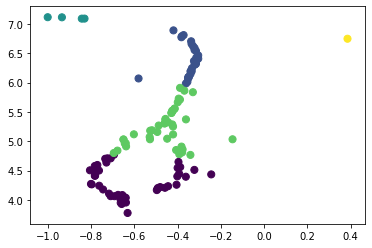

In [21]:
# sklearn
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
# 시각화
import seaborn as sns
import matplotlib.pyplot as plt

# clustering
k = 5
kmeans = KMeans(n_clusters=k, random_state=2021)
y_pred = kmeans.fit_predict(sentence_glove)


# tsne
tsne = TSNE(verbose=1, perplexity=100, random_state=2021)     # perplexity : 유사정도
z = tsne.fit_transform(sentence_glove)

df = pd.DataFrame()
df["y"] = y_pred
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

plt.scatter(z[:,0],z[:,1], c=y_pred, s=50, cmap='viridis')

centers = kmeans.cluster_centers_

In [22]:
index = 0
result = dict()
for i in y_pred:
    #print(i, " : ",check_word[index] )
    if i in result:
        result[i].append(check_word[index])
    else:
        result[i] = [check_word[index]]
    index = index + 1
for i in result:
    print(result[i])
    print('-'*20)

['가격', '것', '제품', '후', '부담', '효과', '중', '원', '딸', '이번', '보니', '첨', '오늘', '통', '년', '젤', '가족', '바', '이상', '세트', '양', '선물', '달', '통', '풀', '속', '판매', '코', '기간', '사람', '양', '다', '상태', '분기', '득', '에', '아', '건강', '서비스', '요', '결정', '입', '아이', '면']
--------------------
['향', '배', '폼', '수', '송', '대비', '때', '전', '굿', '처음', '개', '상품', '마음', '용', '데', '물', '분', '상품', '필', '행사', '배', '결', '관리', '병', '지', '시', '미', '지금', '화', '유', '안전', '추', '결', '담', '대', '일', '강', '몸', '기능', '복합', '도', '데일리', '송', '잔', '강']
--------------------
['거', '솜', '듯', '감사', '맘', '쑥', '팩', '평', '최고', '감', '여름', '편', '예', '건', '순', '링', '갑', '안', '형', '날', '만', '눈', '앞', '말', '집', '동안', '호', '손', '점', '티']
--------------------
['번', '인지', '애', '음']
--------------------
['게']
--------------------


In [ ]:
# TextRank 중요문장 10개 추출
from textranks.textrank import KeysentenceSummarizer
from konlpy.tag import Komoran

komoran = Komoran()

summarizer = KeysentenceSummarizer(
    tokenize = komoran_tokenizer,
    min_sim = 0.3,
    verbose = False
)


keysents = summarizer.summarize(list(df2)[:], topk=100)


In [ ]:

for i in keysents:
    print(i)

In [ ]:
from pororo import Pororo
summ = Pororo(task="summarization", model="abstractive", lang="ko")
